In [1]:
import json
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from collections import Counter

In [2]:
# Define the path to your file
import os

# Define the directory path and file names
directory_path = "D:/Yelp_JSON/Yelp JSON/yelp_dataset"
file_names = ['business', 'checkin', 'review', 'tip', 'user']

# Dataset variables
dataframes = {}

# Read each file in chunks and store in a dictionary
chunk_size = 10000

for name in file_names:
    file_path = os.path.join(directory_path, f"yelp_academic_dataset_{name}.json")
    
    chunks = []
    
    with open(file_path, 'r', encoding='utf-8') as data_file:
        buffer = []
        for i, line in enumerate(data_file):
            buffer.append(json.loads(line))
            
            # When buffer reaches chunk_size, convert to DataFrame and reset buffer
            if (i + 1) % chunk_size == 0:
                chunks.append(pd.DataFrame(buffer))
                buffer = []
        
        # Add any remaining data
        if buffer:
            chunks.append(pd.DataFrame(buffer))
    
    # Concatenate all chunks into a single DataFrame
    dataframes[name] = pd.concat(chunks, ignore_index=True)

# Unpack the dataframes
business_df = dataframes['business']
checkin_df = dataframes['checkin']
review_df = dataframes['review']
tip_df = dataframes['tip']
user_df = dataframes['user']

business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [3]:
# Clear any potential duplicates by their business ids
business_df = business_df.drop_duplicates(subset=['business_id'])
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [4]:
# Some places like the UPS and Target are in the data, and they are not what we want
restaurant_keywords = ["Restaurant", "Food", "Café", "Coffee", "Bakery", "Bar", "Tea"]

# Function to check if a business is a restaurant
def is_restaurant(category):
    if isinstance(category, str):  # Ensure it's a string
        return any(keyword in category for keyword in restaurant_keywords)
    return False  # If category is missing or NaN, return False

# Apply the filter to keep only restaurants
restaurant_df = business_df[business_df['categories'].apply(is_restaurant)]
restaurant_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,1,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."
8,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,0,"{'Caters': 'True', 'Alcohol': 'u'full_bar'', '...","Pubs, Restaurants, Italian, Bars, American (Tr...",None
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,1,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '..."


In [5]:
# The column 'is_open' is the temporary status of the restaurant when the dataset was collected, and does not provide much information.
restaurant_usable = restaurant_df.drop(columns='is_open')
restaurant_usable.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,categories,hours
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '..."
8,k0hlBqXX-Bt0vf1op7Jr1w,Tsevi's Pub And Grill,8025 Mackenzie Rd,Affton,MO,63123,38.565165,-90.321087,3.0,19,"{'Caters': 'True', 'Alcohol': 'u'full_bar'', '...","Pubs, Restaurants, Italian, Bars, American (Tr...",None
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '..."


In [6]:
# Since we want only restaurants in the US, the rows representing restaurants located in Canada, Mexico, or other countries should be dropped.
us_states = {
    "AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", "HI", "ID", "IL", "IN", "IA",
    "KS", "KY", "LA", "ME", "MD", "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ",
    "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", "SD", "TN", "TX", "UT", "VT",
    "VA", "WA", "WV", "WI", "WY"
}

us_restaurants = restaurant_usable[restaurant_usable['state'].isin(us_states)]
us_restaurants = us_restaurants.dropna(subset=['postal_code', 'stars', 'review_count', 'attributes', 'hours'])
us_restaurants.shape

(56023, 13)

In [7]:
# Check for unusual values
print(us_restaurants['stars'].describe())

# Keep only valid ratings (between 1 and 5)
us_restaurants = us_restaurants[(us_restaurants['stars'] >= 1) & (us_restaurants['stars'] <= 5)]

# Remove restaurants with fewer than 5 reviews
us_restaurants = us_restaurants[us_restaurants['review_count'] >= 5]
us_restaurants['stars'] = us_restaurants['stars'].astype(float)
us_restaurants['review_count'] = us_restaurants['review_count'].astype(int)
us_restaurants['postal_code'] = us_restaurants['postal_code'].astype(str)

us_restaurants.shape

count    56023.000000
mean         3.594131
std          0.850839
min          1.000000
25%          3.000000
50%          3.500000
75%          4.000000
max          5.000000
Name: stars, dtype: float64


(56023, 13)

In [8]:
# Function to extract days and time spans
def extract_hours(hours):
    if isinstance(hours, dict):  # Ensure it's a dictionary
        open_days = list(hours.keys())
        time_spans = list(hours.values())
        return open_days, time_spans
    return [], []

# Apply the function to create new columns
us_restaurants['open_days'], us_restaurants['time_span'] = zip(*us_restaurants['hours'].apply(extract_hours))
us_restaurants.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,categories,hours,open_days,time_span
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...","[Monday, Tuesday, Wednesday, Thursday, Friday,...","[7:0-20:0, 7:0-20:0, 7:0-20:0, 7:0-20:0, 7:0-2..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...","[Wednesday, Thursday, Friday, Saturday, Sunday]","[14:0-22:0, 16:0-22:0, 12:0-22:0, 12:0-22:0, 1..."
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...","[Monday, Tuesday, Wednesday, Thursday, Friday,...","[0:0-0:0, 6:0-22:0, 6:0-22:0, 6:0-22:0, 9:0-0:..."
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...","[Monday, Tuesday, Wednesday, Thursday, Friday,...","[0:0-0:0, 6:0-21:0, 6:0-21:0, 6:0-16:0, 6:0-16..."
11,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","Vietnamese, Food, Restaurants, Food Trucks","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'...","[Monday, Tuesday, Wednesday, Thursday, Friday,...","[11:0-14:0, 11:0-14:0, 11:0-14:0, 11:0-14:0, 1..."


In [9]:
us_restaurants['attributes'].dropna().sample(n=30)

136327    {'RestaurantsDelivery': 'True', 'OutdoorSeatin...
70312     {'RestaurantsPriceRange2': '2', 'RestaurantsAt...
92404     {'HasTV': 'True', 'RestaurantsTakeOut': 'True'...
31303     {'RestaurantsPriceRange2': '2', 'RestaurantsTa...
149032    {'NoiseLevel': 'u'loud'', 'BusinessAcceptsCred...
78877     {'OutdoorSeating': 'False', 'BusinessParking':...
4211      {'BusinessAcceptsCreditCards': 'True', 'Restau...
2042      {'Ambience': '{'romantic': False, 'intimate': ...
129975    {'NoiseLevel': 'u'average'', 'BusinessParking'...
80007     {'BusinessAcceptsCreditCards': 'False', 'Resta...
38637     {'RestaurantsTakeOut': 'True', 'RestaurantsDel...
97393     {'Ambience': '{'romantic': False, 'intimate': ...
28617     {'BusinessAcceptsCreditCards': 'True', 'Busine...
113860    {'NoiseLevel': ''average'', 'RestaurantsTakeOu...
81413     {'RestaurantsDelivery': 'True', 'BusinessAccep...
92313     {'BikeParking': 'True', 'BusinessParking': '{'...
12519     {'RestaurantsPriceRange2': '2'

In [10]:
attribute_counts = Counter()

# Iterate over non-null attribute dictionaries
for attr in us_restaurants['attributes'].dropna():
    if isinstance(attr, dict):
        attribute_counts.update(attr.keys())

# Get the 5 most frequent attribute keys
top_attributes = [attr[0] for attr in attribute_counts.most_common(5)]

# Extract the 5 most frequent attributes into separate columns
for attr in top_attributes:
    us_restaurants[attr] = us_restaurants['attributes'].apply(lambda x: x.get(attr) if isinstance(x, dict) else None)

us_restaurants.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,categories,hours,open_days,time_span,BusinessAcceptsCreditCards,BusinessParking,RestaurantsTakeOut,RestaurantsPriceRange2,RestaurantsDelivery
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...","[Monday, Tuesday, Wednesday, Thursday, Friday,...","[7:0-20:0, 7:0-20:0, 7:0-20:0, 7:0-20:0, 7:0-2...",False,"{'garage': False, 'street': True, 'validated':...",True,1,False
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...","[Wednesday, Thursday, Friday, Saturday, Sunday]","[14:0-22:0, 16:0-22:0, 12:0-22:0, 12:0-22:0, 1...",True,"{'garage': None, 'street': None, 'validated': ...",True,None,None
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,"{'BusinessParking': 'None', 'BusinessAcceptsCr...","Burgers, Fast Food, Sandwiches, Food, Ice Crea...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...","[Monday, Tuesday, Wednesday, Thursday, Friday,...","[0:0-0:0, 6:0-22:0, 6:0-22:0, 6:0-22:0, 9:0-0:...",True,None,True,1,True
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,"{'RestaurantsAttire': ''casual'', 'Restaurants...","Ice Cream & Frozen Yogurt, Fast Food, Burgers,...","{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...","[Monday, Tuesday, Wednesday, Thursday, Friday,...","[0:0-0:0, 6:0-21:0, 6:0-21:0, 6:0-16:0, 6:0-16...",True,"{'garage': False, 'street': False, 'validated'...",True,1,True
11,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,"{'Alcohol': ''none'', 'OutdoorSeating': 'None'...","Vietnamese, Food, Restaurants, Food Trucks","{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'...","[Monday, Tuesday, Wednesday, Thursday, Friday,...","[11:0-14:0, 11:0-14:0, 11:0-14:0, 11:0-14:0, 1...",None,"{'garage': False, 'street': False, 'validated'...",None,None,None


In [11]:
us_restaurants['BusinessParking'].dropna().sample(n=30)

108514    {'garage': False, 'street': False, 'validated'...
107131    {'garage': False, 'street': False, 'validated'...
87077                                                  None
145032    {'garage': False, 'street': False, 'validated'...
33282     {'garage': False, 'street': None, 'validated':...
28909     {'garage': False, 'street': True, 'validated':...
12970     {'garage': False, 'street': True, 'validated':...
40094     {u'valet': False, u'garage': False, u'street':...
103315    {'garage': False, 'street': False, 'validated'...
36148     {'garage': False, 'street': True, 'validated':...
123276    {'garage': None, 'street': True, 'validated': ...
17219     {'garage': False, 'street': False, 'validated'...
78368     {'garage': False, 'street': True, 'validated':...
150020    {'garage': False, 'street': False, 'validated'...
28580     {'garage': False, 'street': False, 'validated'...
96341     {'garage': False, 'street': False, 'validated'...
147785    {'garage': False, 'street': Tr

In [12]:
# The above sample does not show a lot of restaurants with good parking availability
def count_parking_types(parking):
    if isinstance(parking, str):  # It's actually a string, not a dict
        try:
            parking = ast.literal_eval(parking)  # Safely convert string to dict
        except:
            return 0  # If conversion fails, assume no parking
        
    if isinstance(parking, dict):  # Ensure it's a dictionary
        return sum(1 for key, value in parking.items() if str(value).lower() == 'true')  # Count True values
    return 0  # Return 0 if parking info is missing

# Apply function to create a Parking Score
us_restaurants["Parking"] = us_restaurants["BusinessParking"].apply(count_parking_types)

# Define segmentation labels
def categorize_parking(score):
    if score == 0:
        return "No Parking"
    elif score < 3:
        return "Limited Parking"
    else:
        return "Excellent Parking"

# Create a new segment column
us_restaurants["Parking_Category"] = us_restaurants["Parking"].apply(categorize_parking)
us_restaurants.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,hours,open_days,time_span,BusinessAcceptsCreditCards,BusinessParking,RestaurantsTakeOut,RestaurantsPriceRange2,RestaurantsDelivery,Parking,Parking_Category
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...","[Monday, Tuesday, Wednesday, Thursday, Friday,...","[7:0-20:0, 7:0-20:0, 7:0-20:0, 7:0-20:0, 7:0-2...",False,"{'garage': False, 'street': True, 'validated':...",True,1,False,1,Limited Parking
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,...,"{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...","[Wednesday, Thursday, Friday, Saturday, Sunday]","[14:0-22:0, 16:0-22:0, 12:0-22:0, 12:0-22:0, 1...",True,"{'garage': None, 'street': None, 'validated': ...",True,None,None,1,Limited Parking
5,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,...,"{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...","[Monday, Tuesday, Wednesday, Thursday, Friday,...","[0:0-0:0, 6:0-22:0, 6:0-22:0, 6:0-22:0, 9:0-0:...",True,None,True,1,True,0,No Parking
9,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,...,"{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...","[Monday, Tuesday, Wednesday, Thursday, Friday,...","[0:0-0:0, 6:0-21:0, 6:0-21:0, 6:0-16:0, 6:0-16...",True,"{'garage': False, 'street': False, 'validated'...",True,1,True,0,No Parking
11,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,...,"{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'...","[Monday, Tuesday, Wednesday, Thursday, Friday,...","[11:0-14:0, 11:0-14:0, 11:0-14:0, 11:0-14:0, 1...",None,"{'garage': False, 'street': False, 'validated'...",None,None,None,0,No Parking


In [13]:
print(us_restaurants.iloc[0]['BusinessParking']) # should expect only 1 true label

{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}


In [14]:
us_restaurants.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56023 entries, 3 to 150339
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   business_id                 56023 non-null  object 
 1   name                        56023 non-null  object 
 2   address                     56023 non-null  object 
 3   city                        56023 non-null  object 
 4   state                       56023 non-null  object 
 5   postal_code                 56023 non-null  object 
 6   latitude                    56023 non-null  float64
 7   longitude                   56023 non-null  float64
 8   stars                       56023 non-null  float64
 9   review_count                56023 non-null  int32  
 10  attributes                  56023 non-null  object 
 11  categories                  56023 non-null  object 
 12  hours                       56023 non-null  object 
 13  open_days                   56023 n

In [15]:
business_df_cleaned = us_restaurants.reset_index(drop=True)
business_df_cleaned.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,...,hours,open_days,time_span,BusinessAcceptsCreditCards,BusinessParking,RestaurantsTakeOut,RestaurantsPriceRange2,RestaurantsDelivery,Parking,Parking_Category
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,...,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...","[Monday, Tuesday, Wednesday, Thursday, Friday,...","[7:0-20:0, 7:0-20:0, 7:0-20:0, 7:0-20:0, 7:0-2...",False,"{'garage': False, 'street': True, 'validated':...",True,1,False,1,Limited Parking
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,...,"{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2...","[Wednesday, Thursday, Friday, Saturday, Sunday]","[14:0-22:0, 16:0-22:0, 12:0-22:0, 12:0-22:0, 1...",True,"{'garage': None, 'street': None, 'validated': ...",True,None,None,1,Limited Parking
2,CF33F8-E6oudUQ46HnavjQ,Sonic Drive-In,615 S Main St,Ashland City,TN,37015,36.269593,-87.058943,2.0,6,...,"{'Monday': '0:0-0:0', 'Tuesday': '6:0-22:0', '...","[Monday, Tuesday, Wednesday, Thursday, Friday,...","[0:0-0:0, 6:0-22:0, 6:0-22:0, 6:0-22:0, 9:0-0:...",True,None,True,1,True,0,No Parking
3,bBDDEgkFA1Otx9Lfe7BZUQ,Sonic Drive-In,2312 Dickerson Pike,Nashville,TN,37207,36.208102,-86.768170,1.5,10,...,"{'Monday': '0:0-0:0', 'Tuesday': '6:0-21:0', '...","[Monday, Tuesday, Wednesday, Thursday, Friday,...","[0:0-0:0, 6:0-21:0, 6:0-21:0, 6:0-16:0, 6:0-16...",True,"{'garage': False, 'street': False, 'validated'...",True,1,True,0,No Parking
4,eEOYSgkmpB90uNA7lDOMRA,Vietnamese Food Truck,,Tampa Bay,FL,33602,27.955269,-82.456320,4.0,10,...,"{'Monday': '11:0-14:0', 'Tuesday': '11:0-14:0'...","[Monday, Tuesday, Wednesday, Thursday, Friday,...","[11:0-14:0, 11:0-14:0, 11:0-14:0, 11:0-14:0, 1...",None,"{'garage': False, 'street': False, 'validated'...",None,None,None,0,No Parking


In [16]:
review_df.isnull().sum()
review_df.shape

(6990280, 9)

In [17]:
restaurant_ids = set(business_df_cleaned["business_id"])
review_df = review_df[review_df["business_id"].isin(restaurant_ids)]
review_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4988734 entries, 0 to 6990279
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   review_id    object 
 1   user_id      object 
 2   business_id  object 
 3   stars        float64
 4   useful       int64  
 5   funny        int64  
 6   cool         int64  
 7   text         object 
 8   date         object 
dtypes: float64(1), int64(3), object(5)
memory usage: 380.6+ MB


In [18]:
review_df["review_score"] = (review_df["useful"] * 0.6) + (review_df["funny"] * 0.2) + (review_df["cool"] * 0.2)
review_df.head()

C:\Users\dell\AppData\Local\Temp\ipykernel_6740\2400787992.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_df["review_score"] = (review_df["useful"] * 0.6) + (review_df["funny"] * 0.2) + (review_df["cool"] * 0.2)


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,review_score
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,0.0
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,0.8
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,0.8
5,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31,1.2
7,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5.0,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16,1.2


In [19]:
business_review_counts = review_df.groupby("business_id")["review_id"].count().reset_index()

# Filter businesses that have at least 5 reviews
businesses_with_5_reviews = business_review_counts[business_review_counts["review_id"] >= 5]
businesses_with_5_reviews.head()

,business_id,review_id
0,---kPU91CF4Lq2-WlRu9Lw,24
1,--8IbOsAAxjKRoYsBFL-PA,27
2,--ARBQr1WMsTWiwOKOj-FQ,23
3,--MbOh2O1pATkXa7xbU6LA,27
4,--SJXpAa0E-GCp2smaHf0A,13


In [20]:
review_df = review_df[review_df["business_id"].isin(businesses_with_5_reviews["business_id"])]
review_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4988734 entries, 0 to 6990279
Data columns (total 10 columns):
 #   Column        Dtype  
---  ------        -----  
 0   review_id     object 
 1   user_id       object 
 2   business_id   object 
 3   stars         float64
 4   useful        int64  
 5   funny         int64  
 6   cool          int64  
 7   text          object 
 8   date          object 
 9   review_score  float64
dtypes: float64(2), int64(3), object(5)
memory usage: 418.7+ MB


In [21]:
businesses_with_5_reviews.shape

(56023, 2)

In [22]:
review_df["business_id"].nunique()

56023

In [23]:
"""
 This matches the above shape of businesses_with_3_reviews, we have 56023 restaurants with more than 5 reviews. 
 We also know that all of these businesses are restaurants from the initial query.
 In the cleaned version of business_df there are 56023 unique restaurants, which leads to the conclusion that 
 all the restaurants in the business_df dataframe have more than 5 reviews and are considered usable.
"""
review_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,review_score
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3.0,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,0.0
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5.0,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,0.8
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4.0,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,0.8
5,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1.0,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31,1.2
7,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5.0,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16,1.2


In [28]:
# business_df_cleaned.to_csv('business.csv.gz', index=False, compression='gzip')
checkin_df.to_csv('checkin.csv.gz', index=False, compression='gzip')
review_df.to_csv('review.csv.gz', index=False, compression='gzip')
tip_df.to_csv('tip.csv.gz', index=False, compression='gzip')
user_df.to_csv('user.csv.gz', index=False, compression='gzip')


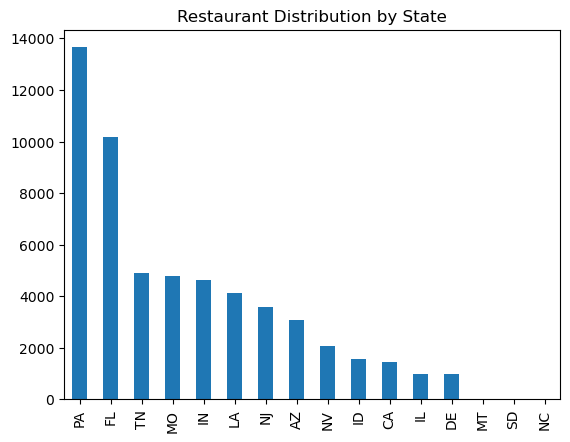

In [31]:
business_df_cleaned.state.value_counts().plot.bar()
plt.title('Restaurant Distribution by State')
plt.show()

In [32]:
business_df_cleaned = business_df_cleaned[~business_df_cleaned['state'].isin(['NC', 'MT', 'SD'])]

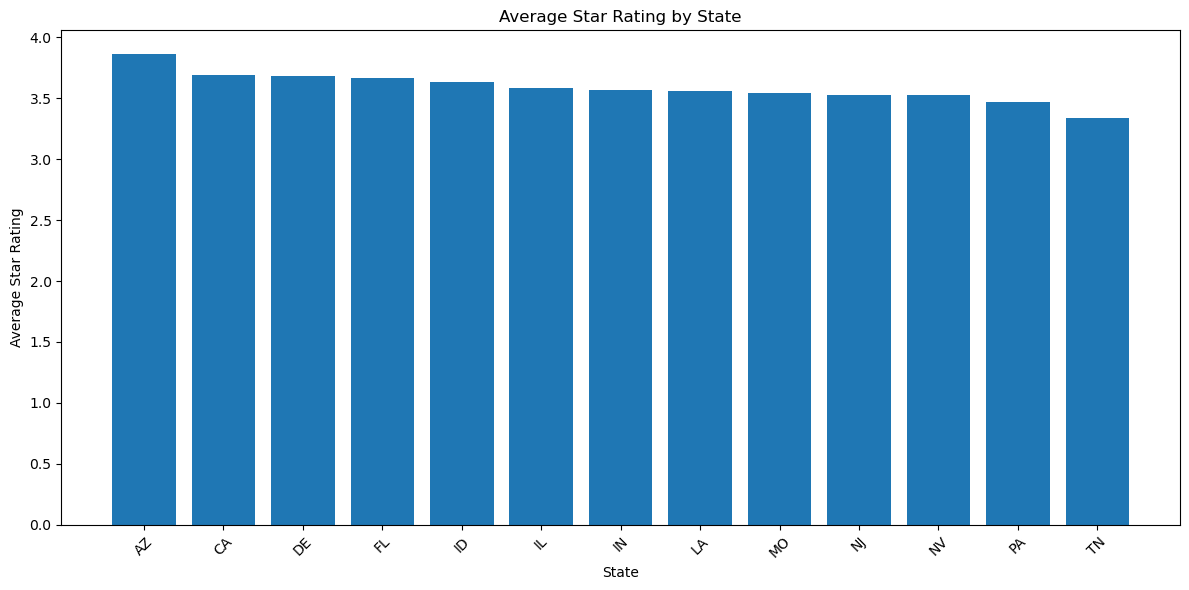

In [33]:
# Average rating by state
avg_rate = business_df_cleaned.groupby('state')['stars'].mean().reset_index(name = 'average_stars')

plt.figure(figsize=(12, 6))
plt.bar(avg_rate['state'], avg_rate['average_stars'].sort_values(ascending =False))
plt.title('Average Star Rating by State')
plt.xlabel('State')
plt.ylabel('Average Star Rating')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

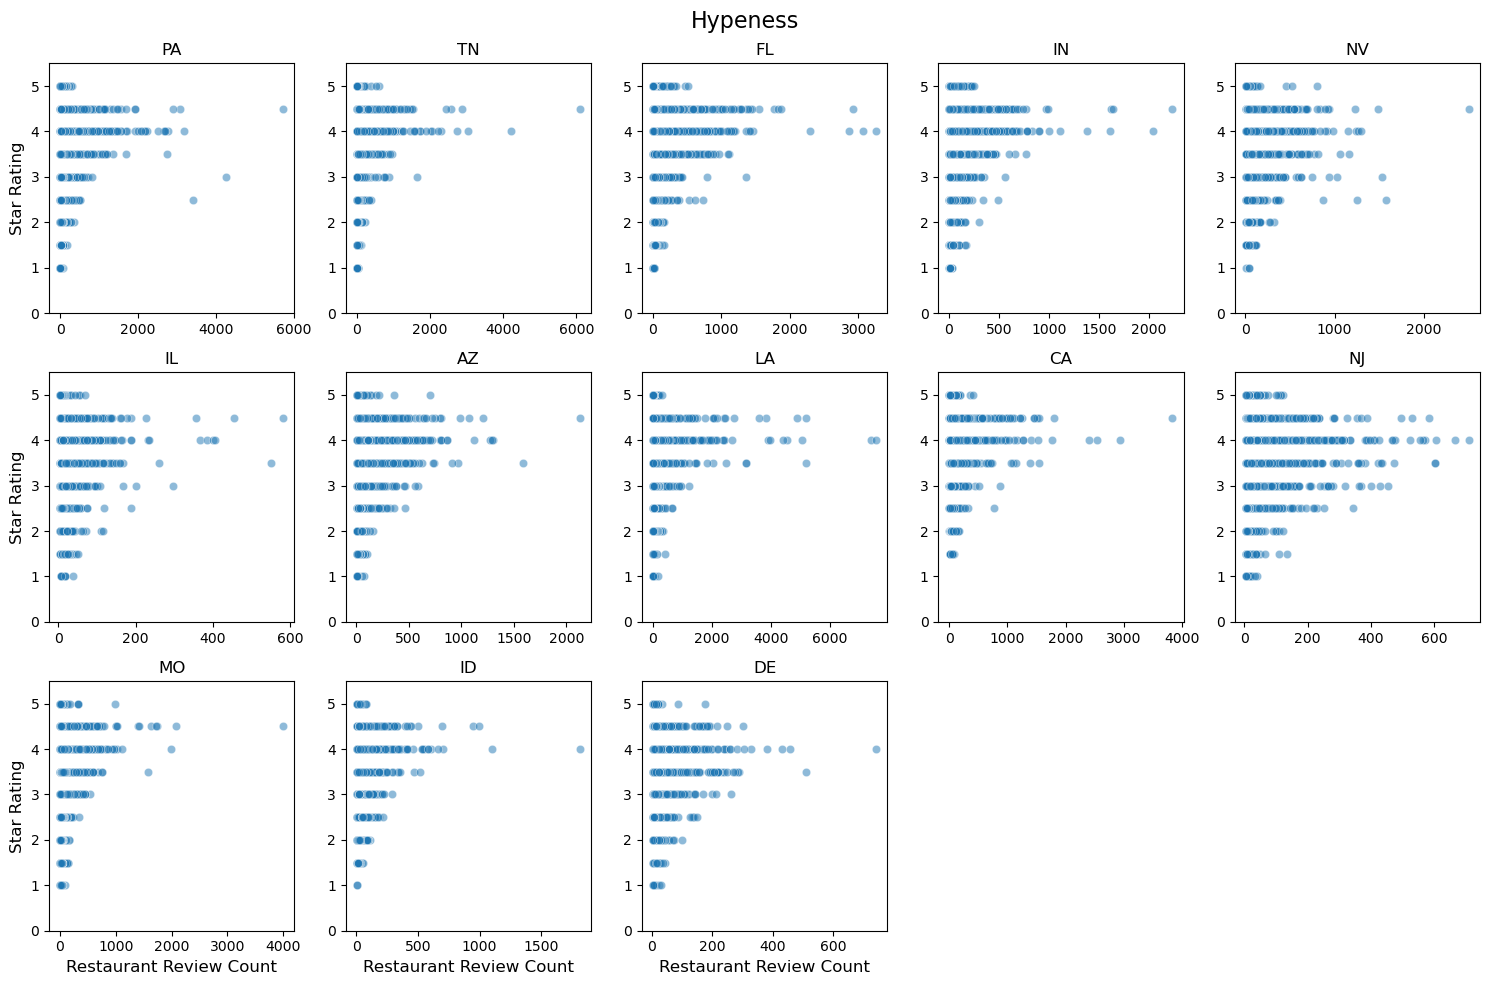

In [34]:
# Rating and review count correlation 
states = business_df_cleaned['state'].unique()

# Create subplots
fig, axes = plt.subplots(3, 5, figsize=(15, 10))

# Flatten the axes array for easy indexing
axes = axes.flatten()

# Loop over each state and plot a bar plot for rating distribution
for i, state in enumerate(states):
    sns.scatterplot(x=business_df_cleaned[business_df_cleaned['state'] == state]['review_count'], 
                    y=business_df_cleaned[business_df_cleaned['state'] == state]['stars'], 
                    ax=axes[i], alpha=0.5)
    axes[i].set_title(f"{state}")
    axes[i].set_xlabel('')  # Remove x-axis label
    axes[i].set_ylabel('')  # Remove y-axis label
    if i % 5 == 0:  # Leftmost plot in each row (first column)
        axes[i].set_ylabel('Star Rating', fontsize=12)
    if i // 5 == 2:  # Bottommost plot in each column (third row)
        axes[i].set_xlabel('Restaurant Review Count', fontsize=12)
    axes[i].set_ylim(0, 5.5)

for j in range(13, 15):
    fig.delaxes(axes[j])

plt.suptitle('Hypeness', fontsize=16)
fig.tight_layout()
plt.show()